## TorchVision Object Detection Finetuning Tutorial

In [1]:
from datetime import datetime

now = datetime.now().strftime("%a, %d %b %Y %H:%M:%S")

print(f"Created date: Mon, 01 Apr 2024 17:00:51")
print(f"Modified date: {now}")

Created date: Mon, 01 Apr 2024 17:00:51
Modified date: Mon, 22 Apr 2024 01:49:28


In [2]:
# install pycocotools
# !pip install pycocotools # pycocotools==2.0.7

In [3]:
from pathlib import Path 
import gdown
import os

### Writing a custom dataset for PennFudan

#### 1. Download `PennFudan` dataset 

In [4]:
# data directory
data_dir = Path("data")
if not data_dir.is_dir():
    data_dir.mkdir(parents=True, exist_ok=True)

# data_url
data_url = "https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip"

# zip_file_name
data_zip_file_name = "PennFudanPed.zip"

# zip_file path
data_zip_file_path = data_dir.joinpath(data_zip_file_name)


# download data
if not data_zip_file_path.is_file():

    try:
        gdown.download(url=data_url, output=str(data_zip_file_path))
    except Exception as e:

        print(f"Caught this error: {e}")

else:
    print(f"The {data_zip_file_name} already existed")


# folder_name
data_folder_name = "PennFudanPed"

# data_folder path
data_folder_path = data_dir.joinpath(data_folder_name)


# extract data
if not data_folder_path.is_dir():

    try:
        gdown.extractall(path=str(data_zip_file_path), to=data_dir)
    except Exception as e:

        print(f"Caught this error: {e}")

    print(f"Extracted the {data_zip_file_name} successful")

else:
    print(f"The {data_zip_file_name} already extracted")


The PennFudanPed.zip already existed
The PennFudanPed.zip already extracted


In [5]:
# list all files and directories from data
os.listdir(data_folder_path)

['added-object-list.txt', 'PNGImages', 'Annotation', 'readme.txt', 'PedMasks']

In [6]:
# listing all png images from downloaded_data
PNGImages_path = data_folder_path.joinpath("PNGImages")

PNGImages = []
for dirpath, dirnames, filenames in os.walk(PNGImages_path):
    if len(filenames) > 0:
        print(f"There are {len(filenames)} images in {dirpath}")

        PNGImages = filenames.copy()

# listing all masked images from downloaded_data
PedMasks_path = data_folder_path.joinpath("PedMasks")

PedMasks = []
for dirpath, dirnames, filenames in os.walk(PedMasks_path):
    if len(filenames) > 0:
        print(f"There are {len(filenames)} images in {dirpath}")

        PedMasks = filenames.copy()

There are 170 images in data/PennFudanPed/PNGImages
There are 170 images in data/PennFudanPed/PedMasks


#### 2. Display randomly some images from `PennFudan` dataset

/opt/conda/envs/py_3.10/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


PNGImage_filepath: data/PennFudanPed/PNGImages/FudanPed00023.png
PedMask_filepath: data/PennFudanPed/PedMasks/FudanPed00023_mask.png


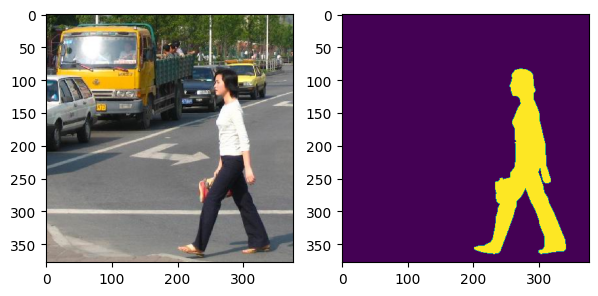

In [7]:
from matplotlib import pyplot as plt 
from torchvision.io import read_image
import random

PNGImage_filename = random.choice(PNGImages)
PNGImage_filepath = str(PNGImages_path.joinpath(PNGImage_filename))

PedMask_filename = PNGImage_filename.replace(".png", "_mask.png")
PedMask_filepath = str(PedMasks_path.joinpath(PedMask_filename))

print(f"PNGImage_filepath: {PNGImage_filepath}")
print(f"PedMask_filepath: {PedMask_filepath}")

# display png image and ped_mask
figure = plt.figure(figsize=(7, 5))

# png image
png_image = read_image(PNGImage_filepath)
plt.subplot(121)
plt.imshow(png_image.permute(1,2,0))

# masked image
masked_image = read_image(PedMask_filepath)
plt.subplot(122)
plt.imshow(masked_image.permute(1,2,0))


In [8]:
import torch

# instances are encoded as different colors
obj_ids = torch.unique(masked_image)

print(f"Number of instances in the image: {len(obj_ids[1:])}") # the first one is the background

Number of instances in the image: 1


In [9]:
masked_image.shape

torch.Size([1, 378, 376])

In [10]:
obj_ids[0].shape

torch.Size([])

In [11]:
obj_ids[:, None, None]

tensor([[[0]],

        [[1]]], dtype=torch.uint8)

In [12]:
obj_ids[:, None, None][0].shape

torch.Size([1, 1])

In [13]:
masked_image == obj_ids[:, None, None]

tensor([[[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])

`np.newaxis` is an alias for `None`.

Some examples may use `None` instead of `np.newaxis`

In [14]:
import numpy as np 

# https://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.expand_dims.html
if np.newaxis is None:
    print("np.newaxis is an alias for None.") 

np.newaxis is an alias for None.


In [15]:
labels = np.array([1, 3, 5])
labels, labels.shape

(array([1, 3, 5]), (3,))

In [16]:
expanded_labels = labels[:, None]
expanded_labels, expanded_labels.shape

(array([[1],
        [3],
        [5]]),
 (3, 1))

In [17]:
output = np.arange(8)
output, output.shape

(array([0, 1, 2, 3, 4, 5, 6, 7]), (8,))

In [18]:
output == labels[:, None]

array([[False,  True, False, False, False, False, False, False],
       [False, False, False,  True, False, False, False, False],
       [False, False, False, False, False,  True, False, False]])

In [19]:
(output == labels[:, None]).shape

(3, 8)

In [20]:
output == labels[:, None, None]

array([[[False,  True, False, False, False, False, False, False]],

       [[False, False, False,  True, False, False, False, False]],

       [[False, False, False, False, False,  True, False, False]]])

In [21]:
(output == labels[:, None, None]).shape

(3, 1, 8)

#### 3. Write a custom dataset for PennDudan

In [26]:
import os 
import torch

from torchvision.io  import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F 

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms

        # load all image files, sorting them to ensure that they are alighed
        ## images
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))

        ## masks
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        
        # get paths of images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])

        # read images and masks
        img = read_image(img_path)
        mask = read_image(mask_path)

        # get all instances from the mask 
        obj_ids = torch.unique(mask)

        # remove the first id (the background) 
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        
        # split the color-encoded mask into a set of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)
        
        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # wrap sample and targets into torchvision tv_tensors
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_image_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target
    
    def __len__(self):
        return len(self.imgs)


### 4. Defining the model

This using Mask R-CNN, which is based on top of Faster R-CNN.

Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

Mask R-CNN adds an extra branch into Faster R-CNN, which is also predicts segmentation masks for each instance.

There are 2 common situations
1. Start from a pre-trained model, and just finetune the last layer.
2. Replace the backbone of the model with a different one (for faster predictions)

#### 1. Finetuning from the pretrained model

In [27]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has num_classes which is user-defined
num_classes = 2 # 1 class (persion) + background

# get number of input features for the classidier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /var/lib/ci-user/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:15<00:00, 11.1MB/s] 


**Object detection and instance segmentation model for PennFudan Dataset**

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor




#### References

1. https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html